# Sparkify Project Notebook

> This notebook was developed as part of Udacity's Sparkify Capstone Project, which was one of the possible final projects to tackle in the Data Scientist Nanodegree Program (cohort of Aug-Dec 2019).

Sparkify is a fictional service similar to [Spotify](https://en.wikipedia.org/wiki/Spotify). At a high level, users can come and play songs from a large pool of artists either as a guest or as a logged-in user. They can also decide to pay for the service for more benefits. They're also free to unsubscribe from the service at any time. 

Udacity's is graciously providing both a medium (128MB) and large (12GB) dataset with user activity events to play with. For example, a row might represent the action of a particular user playing a song from the artist "Metallica". We want to use this dataset to try to predict if an user will churn in the near future (in this case, unsubscribe from the service).

Predicting churn is a challenging and common problem that data scientists and analysts regularly encounter in any customer-facing business. Additionally, the ability to efficiently manipulate large datasets with Spark is one of the highest-demand skills in the field of data.

This work shows how [pyspark](https://pypi.org/project/pyspark/) can be used to craft a machine learning model for predicting user churn. For most of the notebook, the medium sized dataset is used just so we can craft the features needed and to gain confidence in a supervised learning model in a local machine, but results from running the model training and evaluation on the large dataset using [AWS EMR](https://aws.amazon.com/emr/) are shared towards the end. 

## Loading the Data

Let's start by importing all the necessary libraries:

In [78]:
import datetime

import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics
import pyspark.sql.functions as sqlF
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.types import IntegerType

%matplotlib inline

Next let's create the SparkSession we'll be using from this point onward and load the medium dataset for analysis:

In [2]:
# Create the spark session that will be used for the whole notebook
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [3]:
# Read smaller sparkify dataset for the initial exploration phase

# READ ME!!!
# Use the following path instead if you're running from AWS
# file_path = 's3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json'

# Use the following path only when running locally and after downloading datasets
file_path = './datasets/mini_sparkify_event_data.json'

df = spark.read.json(file_path)
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

## Exploring Dataset

Let's start by gathering some high level facts about the dataset:

In [4]:
# Print the schema per entry in the json
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# Print how many rows and columns are in the dataset
df.count(), len(df.columns)

(286500, 18)

In [6]:
def nice_describe(df, jump_size=5):
    """A wrapper around describe that prints `jump_size` columns at a time"""
    ncols = len(df.columns)
    for idx in range(0, ncols, jump_size):
        col_list = df.columns[idx:idx+jump_size]
        print(f'Summary statistics for {col_list}')
        df.describe(col_list).show()

In [7]:
# Print descriptive statistics 5 columns at a time
nice_describe(df)

Summary statistics for ['artist', 'auth', 'firstName', 'gender', 'itemInSession']
+-------+------------------+----------+---------+------+------------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|
+-------+------------------+----------+---------+------+------------------+
|  count|            228108|    286500|   278154|278154|            286500|
|   mean| 551.0852017937219|      null|     null|  null|114.41421291448516|
| stddev|1217.7693079161374|      null|     null|  null|129.76726201141085|
|    min|               !!!| Cancelled| Adelaida|     F|                 0|
|    max| ÃÂlafur Arnalds|Logged Out|   Zyonna|     M|              1321|
+-------+------------------+----------+---------+------+------------------+

Summary statistics for ['lastName', 'length', 'level', 'location', 'method']
+-------+--------+------------------+------+-----------------+------+
|summary|lastName|            length| level|         location|method|
+-------+-------

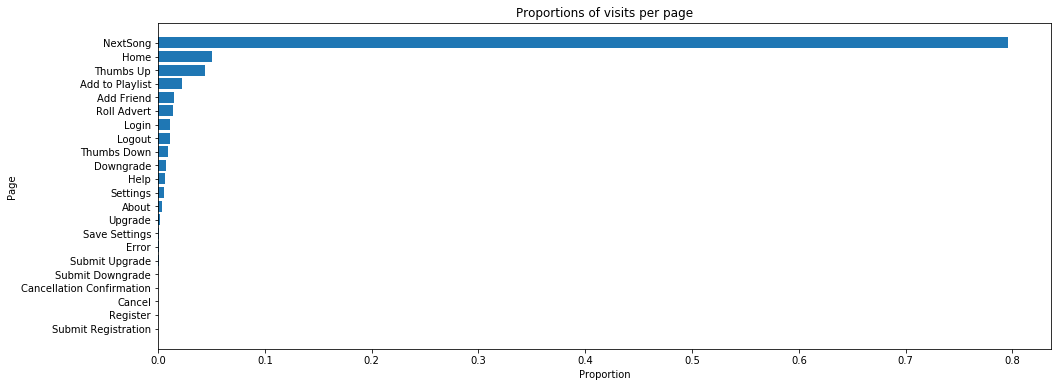

In [75]:
# Show a bar chart with proportions of visits per page
page_counts_pd = df.groupby('page').count().sort('count').toPandas()
page_counts_pd['count'] = page_counts_pd['count'].astype(float)
total_visits = page_counts_pd['count'].sum() 
page_counts_pd['prop'] = page_counts_pd['count'] / total_visits

plt.figure(figsize=(16, 6))
plt.barh(page_counts_pd['page'], page_counts_pd["prop"])
plt.title("Proportions of visits per page")
plt.xlabel("Proportion")
plt.ylabel("Page");

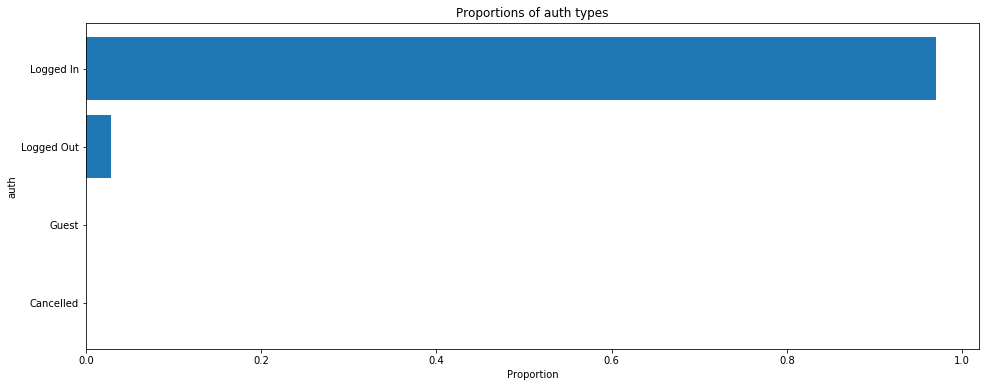

In [74]:
# Show a bar chart with proportions of auth types
auth_counts_pd = df.groupby('auth').count().sort('count').toPandas()
auth_counts_pd['count'] = auth_counts_pd['count'].astype(float)
total_auths = auth_counts_pd['count'].sum() 
auth_counts_pd['prop'] = auth_counts_pd['count'] / total_auths

plt.figure(figsize=(16, 6))
plt.barh(auth_counts_pd['auth'], auth_counts_pd["prop"])
plt.title("Proportions of auth types")
plt.xlabel("Proportion")
plt.ylabel("auth");

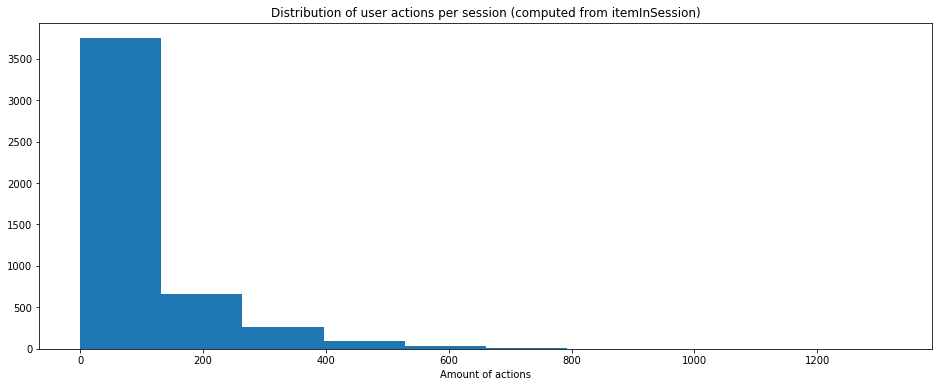

In [79]:
# Distribution of user actions per session (computed itemInSession)
action_counts_pd = df.groupby('userId', 'sessionId') \
    .max() \
    .withColumnRenamed('max(itemInSession)', 'session_actions') \
    .toPandas()

plt.figure(figsize=(16, 6))
plt.hist(action_counts_pd['session_actions'])
plt.title("Distribution of user actions per session (computed from itemInSession)")
plt.xlabel("Amount of actions");

## Cleaning Dataset

We're not missing any `userId`, but it looks like we have rows with empty values. Since we're interested in user churn, then ideally we want to be able to trace back each row to some user's action. Let's explore those rows and then make a decision about what do with them:

In [9]:
# Explore rows with an empty user_id
no_user_df = df.filter('userId == ""')
print(f'Number of rows with empty userId: {no_user_df.count()}')
print('Sample of rows:')
no_user_df.head(3)

Number of rows with empty userId: 8346
Sample of rows:


[Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=100, lastName=None, length=None, level='free', location=None, method='GET', page='Home', registration=None, sessionId=8, song=None, status=200, ts=1538355745000, userAgent=None, userId=''),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=101, lastName=None, length=None, level='free', location=None, method='GET', page='Help', registration=None, sessionId=8, song=None, status=200, ts=1538355807000, userAgent=None, userId=''),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=102, lastName=None, length=None, level='free', location=None, method='GET', page='Home', registration=None, sessionId=8, song=None, status=200, ts=1538355841000, userAgent=None, userId='')]

In [10]:
def show_unique_stats(df, columns, sample_size=5):
    """Function to print unique value stats of specific columns"""
    for col in columns:
        print(f'\nColumn "{col}":')
        uniques = df.select(col).dropDuplicates()
        nuniques = uniques.count()
        print(f'\tNumber of unique values: {nuniques}')
        print(f'\tSample: {uniques.head(sample_size)}')

In [11]:
# Print unique value statistics of all categorical columns for rows with no user_id defined
categorical_cols = ['artist', 'auth', 'firstName', 'gender', 'lastName', 'level', 
                    'location', 'method', 'page', 'song', 'userAgent']
show_unique_stats(no_user_df, categorical_cols, 10)


Column "artist":
	Number of unique values: 1
	Sample: [Row(artist=None)]

Column "auth":
	Number of unique values: 2
	Sample: [Row(auth='Logged Out'), Row(auth='Guest')]

Column "firstName":
	Number of unique values: 1
	Sample: [Row(firstName=None)]

Column "gender":
	Number of unique values: 1
	Sample: [Row(gender=None)]

Column "lastName":
	Number of unique values: 1
	Sample: [Row(lastName=None)]

Column "level":
	Number of unique values: 2
	Sample: [Row(level='free'), Row(level='paid')]

Column "location":
	Number of unique values: 1
	Sample: [Row(location=None)]

Column "method":
	Number of unique values: 2
	Sample: [Row(method='PUT'), Row(method='GET')]

Column "page":
	Number of unique values: 7
	Sample: [Row(page='Home'), Row(page='About'), Row(page='Submit Registration'), Row(page='Login'), Row(page='Register'), Row(page='Help'), Row(page='Error')]

Column "song":
	Number of unique values: 1
	Sample: [Row(song=None)]

Column "userAgent":
	Number of unique values: 1
	Sample: [R

In [12]:
# Explore the rows with no userId and with a paid level
paid_level_df = no_user_df.filter(no_user_df["level"] == "paid")
print(f'Number of rows with no userId defined and a paid level: {paid_level_df.count()}')
print('Sample:')
paid_level_df.head(3)

Number of rows with no userId defined and a paid level: 5729
Sample:


[Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=49, lastName=None, length=None, level='paid', location=None, method='GET', page='Home', registration=None, sessionId=141, song=None, status=200, ts=1538381499000, userAgent=None, userId=''),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=50, lastName=None, length=None, level='paid', location=None, method='PUT', page='Login', registration=None, sessionId=141, song=None, status=307, ts=1538381500000, userAgent=None, userId=''),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=57, lastName=None, length=None, level='paid', location=None, method='GET', page='Home', registration=None, sessionId=141, song=None, status=200, ts=1538382349000, userAgent=None, userId='')]

In [13]:
# Print unique auths for rows with no userId and with a paid level
show_unique_stats(paid_level_df, ['auth', 'page'])


Column "auth":
	Number of unique values: 1
	Sample: [Row(auth='Logged Out')]

Column "page":
	Number of unique values: 5
	Sample: [Row(page='Home'), Row(page='About'), Row(page='Login'), Row(page='Help'), Row(page='Error')]


So either guests or logged out individuals don't have `userId` defined, which makes sense. It was weird to me that rows with no `userId` can have a paid level, but looks like they're coming from users that are logging out and that could just be an artifact from what remains of the user session. 

Given the above, I think is safe to continue just with rows that have user_id defined:

In [14]:
# Because we're interested in user churn, let's remove rows with an empty user_id and
# generate a separate dataframe
df_v2 = df.filter('userId != ""')

In [15]:
# Print summary statistics again to get a sense of impact of the removal
print(f'Number of rows after removing empty user_ids: {df_v2.count()}')
nice_describe(df_v2)

Number of rows after removing empty user_ids: 278154
Summary statistics for ['artist', 'auth', 'firstName', 'gender', 'itemInSession']
+-------+------------------+---------+---------+------+------------------+
|summary|            artist|     auth|firstName|gender|     itemInSession|
+-------+------------------+---------+---------+------+------------------+
|  count|            228108|   278154|   278154|278154|            278154|
|   mean| 551.0852017937219|     null|     null|  null|114.89918174824018|
| stddev|1217.7693079161374|     null|     null|  null|129.85172939949013|
|    min|               !!!|Cancelled| Adelaida|     F|                 0|
|    max| ÃÂlafur Arnalds|Logged In|   Zyonna|     M|              1321|
+-------+------------------+---------+---------+------+------------------+

Summary statistics for ['lastName', 'length', 'level', 'location', 'method']
+-------+--------+------------------+------+-----------------+------+
|summary|lastName|            length| leve

In [16]:
# Print once more unique stats for all categorical variables
show_unique_stats(df_v2, categorical_cols)


Column "artist":
	Number of unique values: 17656
	Sample: [Row(artist='The Black Keys'), Row(artist='Silverstein'), Row(artist='Kate Nash'), Row(artist='Yann Tiersen'), Row(artist="Jane's Addiction")]

Column "auth":
	Number of unique values: 2
	Sample: [Row(auth='Cancelled'), Row(auth='Logged In')]

Column "firstName":
	Number of unique values: 189
	Sample: [Row(firstName='Maddox'), Row(firstName='Karter'), Row(firstName='Lucas'), Row(firstName='Grace'), Row(firstName='Antonina')]

Column "gender":
	Number of unique values: 2
	Sample: [Row(gender='F'), Row(gender='M')]

Column "lastName":
	Number of unique values: 173
	Sample: [Row(lastName='Harrison'), Row(lastName='Thornton'), Row(lastName='Pena'), Row(lastName='Jones'), Row(lastName='Santos')]

Column "level":
	Number of unique values: 2
	Sample: [Row(level='free'), Row(level='paid')]

Column "location":
	Number of unique values: 114
	Sample: [Row(location='Gainesville, FL'), Row(location='Atlantic City-Hammonton, NJ'), Row(locati

## Preparing data for modeling

Our goal is to build a model that can predict the probability of a Sparkify user churning sometime in the future given contextual information about its current state. For that we first need to define what churning means and label the users, then craft some features so we can unlock the ability to construct a supervised learning model.

### Defining Churn

We can define churn as the action of an user unsubscribing from the Sparkify service. During the initial exploration, the `auth` field showed it can take the value `Cancelled` and I anticipate those rows would allow us to identify users that churned. Let's look at a row in such state:

In [19]:
df.where('auth == "Cancelled"').head(1)

[Row(artist=None, auth='Cancelled', firstName='Adriel', gender='M', itemInSession=104, lastName='Mendoza', length=None, level='paid', location='Kansas City, MO-KS', method='GET', page='Cancellation Confirmation', registration=1535623466000, sessionId=514, song=None, status=200, ts=1538943990000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"', userId='18')]

So the user visited the `Cancellation Confirmation` page, so it sounds like it really did churn at that point. Let's explore the timeline of that user in that particular session to help us understand better what happened:

In [17]:
def user_timeline(df, user_id, session_id, cols, n=5):
    """Grab the rows for a particular session of an user and prints the last n actions recorded"""
    user_df = df.where(f'userId={user_id} AND sessionId={session_id}')
    print(f'Number of rows for user with id {user_id} and session id {session_id}: {user_df.count()}')
    user_df.select(cols).sort(sqlF.desc('ts')).show(n)

In [18]:
# Show the timeline of actions for the user with id 18 and session with id 514
user_timeline(df, 18, 514, ['ts', 'sessionId', 'auth', 'page', 'level', 'itemInSession'])

Number of rows for user with id 18 and session id 514: 102
+-------------+---------+---------+--------------------+-----+-------------+
|           ts|sessionId|     auth|                page|level|itemInSession|
+-------------+---------+---------+--------------------+-----+-------------+
|1538943990000|      514|Cancelled|Cancellation Conf...| paid|          104|
|1538943740000|      514|Logged In|              Cancel| paid|          103|
|1538943739000|      514|Logged In|           Downgrade| paid|          102|
|1538943726000|      514|Logged In|            NextSong| paid|          101|
|1538943440000|      514|Logged In|            NextSong| paid|          100|
+-------------+---------+---------+--------------------+-----+-------------+
only showing top 5 rows



The picture starts to make sense now: when the user visits the `Cancellation Confirmation` page at some point, then it follows that the user is no longer `Logged In`. We can validate that:

In [22]:
# Validate that when an user visits the `Cancellation Confirmation` page, then is no longer `Logged In`
cancel_subset_df = df.where('page="Cancellation Confirmation"')
show_unique_stats(cancel_subset_df, ['auth'])


Column "auth":
	Number of unique values: 1
	Sample: [Row(auth='Cancelled')]


In [23]:
# Does a user with a `Cancelled` auth means it can only have visited the `Cancellation Confirmation` page?
auth_subset_df = df.where('auth="Cancelled"')
show_unique_stats(auth_subset_df, ['page'])


Column "page":
	Number of unique values: 1
	Sample: [Row(page='Cancellation Confirmation')]


So given all the above, I think is safe to say that any user that has an auth value of `Cancelled` can be considered churned at that point. Let's work on adding a `churned` column to the dataframe which is marked with 1 if that user churned from the platform at some point, otherwise is marked as 0:

In [19]:
def add_label_churned(df):
    """Returns a new dataframe with the `churned` label: boolean indicating if the user churned at some point"""
    
    # Identify the rows with a cancelled auth state and mark those with 1, then use a window function that groups
    # by users and puts the cancel event at the top (if any) so every row gets a one after that when we sum
    user_cancelled = sqlF.udf(lambda x: 1 if x == 'Cancelled' else 0, IntegerType())
    current_window = Window.partitionBy('userId').orderBy(sqlF.desc('cancelled')).rangeBetween(
        Window.unboundedPreceding, 0)
    churned_df = df.withColumn('cancelled', user_cancelled('auth')) \
        .withColumn("churned", sqlF.sum('cancelled').over(current_window))
    return churned_df.drop('cancelled')

In [20]:
# Add the `churned` label
df = add_label_churned(df)

In [21]:
# Show once again the timeline of actions for the user with id 18 and session with id 514
user_timeline(add_label_churned(df), 18, 514, 
              ['ts', 'sessionId', 'auth', 'page', 'level', 'itemInSession', 'churned'])

Number of rows for user with id 18 and session id 514: 102
+-------------+---------+---------+--------------------+-----+-------------+-------+
|           ts|sessionId|     auth|                page|level|itemInSession|churned|
+-------------+---------+---------+--------------------+-----+-------------+-------+
|1538943990000|      514|Cancelled|Cancellation Conf...| paid|          104|      1|
|1538943740000|      514|Logged In|              Cancel| paid|          103|      1|
|1538943739000|      514|Logged In|           Downgrade| paid|          102|      1|
|1538943726000|      514|Logged In|            NextSong| paid|          101|      1|
|1538943440000|      514|Logged In|            NextSong| paid|          100|      1|
+-------------+---------+---------+--------------------+-----+-------------+-------+
only showing top 5 rows



Before moving on, let's get a sense of general stats for each group so we can use that for inspiration during the feature engineering phase. Below I work on crafting a function that gathers several high level statistics for a dataframe, then run on each group separately for comparison:

In [27]:
def print_relevant_stats(df, total_rows, total_users):
    """"Print high level statistics to get a sense of the properties of the dataframe provided"""
    nrows = df.count()
    nusers = df.select('userId').dropDuplicates().count()
    npaid = df.groupby('userId', 'level').count().where('level == "paid"').count()
    print(f'Proportion of the total rows in this group: {nrows / total_rows:.2f}')
    print(f'Proportion of the total users in this group: {nusers / total_users:.2f}')
    print(f'Proportion of users that paid for the service at some point: {npaid / nusers:.2f}')
    print(f'Proportion of users that have never paid for the service: {(nusers - npaid) / nusers:.2f}')
    
    # The average amount of songs played can be found by grabbing the rows with a song defined
    # and then just grouping by userId to get counts for the calculation
    avg_agg = df.where('song is not null') \
        .groupby('userId') \
        .count() \
        .select(
            sqlF.mean(sqlF.col('count')).alias('avg_songs_played')
        ).head(1)[0]
    print(f'Avg amount of songs played per user: {avg_agg.avg_songs_played:.2f}')
    
    # The average amount of sessions can be calculated from getting unique duplicate pairs of user and session
    # ids and then grouping by user to get the counts for the average calculation
    avg_agg = df.select('userId', 'sessionId') \
        .dropDuplicates() \
        .groupby('userId') \
        .count() \
        .select(
            sqlF.mean(sqlF.col('count')).alias('avg_sessions')
        ).head(1)[0]
    print(f'Avg number of sessions per user: {avg_agg.avg_sessions:.2f}')
    
    # Getting the average actions and lengths per session requires us to find the particular value for each
    # one, which we can get from the max in each group. Then we can proceed to get avg per user, and then
    # a final average across all users
    current_window = Window.partitionBy('userId', 'sessionId').orderBy('ts')
    avg_agg = df.withColumn(
            'sessionLen', (sqlF.col('ts') - sqlF.first(sqlF.col('ts')).over(current_window)) / 1000.0
        ).groupby('userId', 'sessionId') \
        .max() \
        .groupby('userId') \
        .avg() \
        .select(
            sqlF.mean(sqlF.col('avg(max(itemInSession))')).alias('avg_user_actions'),
            sqlF.mean(sqlF.col('avg(max(sessionLen))')).alias('avg_session_len'),
        ).head(1)[0]
    print(f'Avg number of actions per session: {avg_agg.avg_user_actions:.2f}')
    print(f'Avg duration of sessions (in hours): {avg_agg.avg_session_len / (60 * 60):.2f}')
    
    # Getting the average amount of seconds since the first show of users is similar to the above, but this
    # time we don't group by sessionId
    current_window = Window.partitionBy('userId').orderBy('ts')
    avg_agg = df.withColumn(
            'secondsSinceFirstShow', (sqlF.col('ts') - sqlF.first(sqlF.col('ts')).over(current_window)) / 1000.0
        ).groupby('userId') \
        .max() \
        .select(
            sqlF.mean(sqlF.col('max(secondsSinceFirstShow)')).alias('avg_first_show'),
        ).head(1)[0]
    print(f'Avg number of hours since first show: {avg_agg.avg_first_show / (60 * 60):.2f}')
    
    # Calculate not only page visit counts but also percentage of the total for each
    pages_agg = df.groupby('page').count()
    npages = pages_agg.select(sqlF.sum(sqlF.col('count')).alias('npages')).head(1)[0].npages
    per_page_agg = pages_agg.sort(sqlF.desc('count')).withColumn('proportion', sqlF.col('count') / npages)          
    print('Stats per page:')
    per_page_agg.show()

In [23]:
# Get some counts for next steps
total_rows = df.count()
total_users = df.select('userID').dropDuplicates().count()
print(f'Number of rows and users in dataset: {total_rows}, {total_users}')

Number of rows and users in dataset: 286500, 226


In [28]:
print('Stats for set of non-churned users:')
print_relevant_stats(df.where('churned=0'), total_rows, total_users)

Stats for set of non-churned users:
Proportion of the total rows in this group: 0.84
Proportion of the total users in this group: 0.77
Proportion of users that paid for the service at some point: 0.75
Proportion of users that have never paid for the service: 0.25
Avg amount of songs played per user: 1108.17
Avg number of sessions per user: 24.53
Avg number of actions per session: 88.50
Avg duration of sessions (in hours): 5.48
Avg number of hours since first show: 1129.71
Stats per page:
+-------------------+------+--------------------+
|               page| count|          proportion|
+-------------------+------+--------------------+
|           NextSong|191714|  0.7933999900677051|
|               Home| 12785|0.052910162393020904|
|          Thumbs Up| 10692| 0.04424837358671721|
|    Add to Playlist|  5488|0.022711847572381597|
|         Add Friend|  3641|0.015068118988892383|
|              Login|  3241|0.013412736512771277|
|        Roll Advert|  2966|0.012274661060438015|
|      

In [29]:
print('Stats for set of churned users:')
print_relevant_stats(df.where('churned=1'), total_rows, total_users)

Stats for set of churned users:
Proportion of the total rows in this group: 0.16
Proportion of the total users in this group: 0.23
Proportion of users that paid for the service at some point: 0.69
Proportion of users that have never paid for the service: 0.31
Avg amount of songs played per user: 699.88
Avg number of sessions per user: 10.33
Avg number of actions per session: 78.94
Avg duration of sessions (in hours): 4.33
Avg number of hours since first show: 564.35
Stats per page:
+--------------------+-----+--------------------+
|                page|count|          proportion|
+--------------------+-----+--------------------+
|            NextSong|36394|  0.8112072039942939|
|           Thumbs Up| 1859| 0.04143634094151213|
|                Home| 1672|0.037268188302425106|
|     Add to Playlist| 1038|0.023136590584878745|
|         Roll Advert|  967|0.021554029957203995|
|          Add Friend|  636|0.014176176890156919|
|              Logout|  553| 0.01232614122681883|
|         Thu

The results from the above are pretty informative! At a high level, it looks like the more time the user spents in the platform, then the less likely is for the user to churn in the near future. Armed with this information, let's move to the feature engineering phase! 

### Feature Engineering

The dataframe is not yet in a place for us to try to predict churning. What we really want is to have a single set of features per user, but currently each user can have multiple rows because they represent singular actions at points in time as opposed to the current high level characteristics of the user. We did start to summarize properties in the previous section, for example the column `churn` is something that represents current status, but we still need to do more. 

Based on the learnings from the previous section, I plan to concentrate in crafting the following features per user:

- `number_sessions`: Total amount of sessions
- `seconds_since_genesis`: Total amount of seconds since first appearance
- `avg_actions_per_session`: Average amount of actions per session
- `avg_seconds_per_session`: Average amount seconds spent per session

#### Total amount of sessions

This is easy, we just need to get distinct pairs of user and session ids and then group just user ids so we can extract the counts we need:

In [30]:
def add_feature_number_sessions(df):
    """Returns a new dataframe with the `number_sessions` feature: total amount of sessions of the user"""
    counts_df = df.select('userId', 'sessionId') \
        .dropDuplicates() \
        .groupby('userId') \
        .count() \
        .withColumnRenamed('count', 'number_sessions')
    return df.join(counts_df, ['userId'])

In [31]:
# Add number_sessions feature column
features_df = add_feature_number_sessions(df)
features_df.select('userId', 'number_sessions').dropDuplicates().show(n=5)

+------+---------------+
|userId|number_sessions|
+------+---------------+
|100010|              7|
|200002|              6|
|   125|              1|
|   124|             29|
|    51|             10|
+------+---------------+
only showing top 5 rows



#### Total amount of seconds since first appearance

We can get the total amount of seconds since the first user appearance with a window function that calculates the delta of the current timestamp to the first one observed when grouping by user. From there, we just grab the max value obtained for each partition as the final value:

In [32]:
def add_feature_seconds_since_genesis(df):
    """Returns a new dataframe with the `seconds_since_genesis`: seconds since first user appearance"""
    current_window = Window.partitionBy('userId').orderBy('ts')
    genesis_df = df.withColumn('seconds_since_genesis', 
                               (sqlF.col('ts') - sqlF.first(sqlF.col('ts')).over(current_window)) / 1000.0)
    genesis_df = genesis_df.groupby('userId') \
        .max() \
        .withColumnRenamed('max(seconds_since_genesis)', 'seconds_since_genesis') \
        .select('userId', 'seconds_since_genesis')
    return df.join(genesis_df, ['userId'])

In [33]:
# Add hours_since_genesis feature column
features_df = add_feature_seconds_since_genesis(df)
features_df.select('userId', 'seconds_since_genesis').dropDuplicates().sort('seconds_since_genesis').show(n=5)

+------+---------------------+
|userId|seconds_since_genesis|
+------+---------------------+
|   156|                420.0|
|   135|               1347.0|
|   125|               1774.0|
|100011|               2663.0|
|100024|               5115.0|
+------+---------------------+
only showing top 5 rows



#### Average amount of actions per session

To calculate the average session actions per user, we need to group by both user and session id first. From there, the max `itemInSession` column will report the total amount of actions per session. Finally, we can take the average of those and we'll get the value we want:

In [34]:
def add_feature_avg_actions_per_session(df):
    """Returns a new dataframe with the `avg_actions_per_session`: average amount of actions per session"""
    current_window = Window.partitionBy('userId').orderBy('ts')
    avg_df = df.groupby('userId', 'sessionId') \
        .max() \
        .groupby('userId') \
        .avg() \
        .withColumnRenamed('avg(max(itemInSession))', 'avg_actions_per_session') \
        .select('userId', 'avg_actions_per_session')
    return df.join(avg_df, ['userId'])

In [35]:
# Add avg_actions_per_session feature column
features_df = add_feature_avg_actions_per_session(df)
features_df.select('userId', 'avg_actions_per_session').dropDuplicates().sort('avg_actions_per_session').show(n=5)

+------+-----------------------+
|userId|avg_actions_per_session|
+------+-----------------------+
|   135|                    5.0|
|    90|                    8.2|
|   125|                   10.0|
|   134|                  12.25|
|   156|                   14.0|
+------+-----------------------+
only showing top 5 rows



#### Average amount of seconds spent per session

To calculate the average session duration per user we do something similar to the previous case, we just need to construct an intermediate column in the process so we can calculate the running session duration:

In [36]:
def add_feature_avg_seconds_per_session(df):
    """Return a new dataframe with the `avg_seconds_per_session`: average amount of seconds spent per session"""
    current_window = Window.partitionBy('userId', 'sessionId').orderBy('ts')
    avg_df = df.withColumn(
            'sessionLen', (sqlF.col('ts') - sqlF.first(sqlF.col('ts')).over(current_window)) / 1000.0
        ).groupby('userId', 'sessionId') \
        .max() \
        .groupby('userId') \
        .avg() \
        .withColumnRenamed('avg(max(sessionLen))', 'avg_seconds_per_session') \
        .select('userId', 'avg_seconds_per_session')
    return df.join(avg_df, ['userId'])

In [37]:
# Add avg_seconds_per_session feature column
features_df = add_feature_avg_seconds_per_session(df)
features_df.select('userId', 'avg_seconds_per_session').dropDuplicates().sort('avg_seconds_per_session').show(n=5)

+------+-----------------------+
|userId|avg_seconds_per_session|
+------+-----------------------+
|   156|                  420.0|
|   135|                 1347.0|
|   125|                 1774.0|
|    90|                 1782.4|
|   134|                2124.75|
+------+-----------------------+
only showing top 5 rows



#### Putting it all together

We now have all the pieces in place to create a function that loads the dataset, cleans it, adds the features and labels, and reduces into a form in which one row is kept per user with just the features and predicting label:

In [38]:
def load_df_for_ml(json_filepath):
    """Read the json dataset into a dataframe, then clean it and transform it for modeling"""
    
    print(f'Loading datframe from "{json_filepath}"...')
    df = spark.read.json(json_filepath)
    print(f'Loaded {df.count()} rows')
    
    print(f'Removing rows with a blank userId...')
    df_clean_v1 = df.filter('userId != ""')
    print(f'{df.count() - df_clean_v1.count()} rows were removed')
                      
    print(f'Removing rows with a null user id, session id, or timestamp...')
    df_clean_v2 = df_clean_v1.filter('userId IS NOT NULL AND sessionId is not NULL AND ts IS NOT NULL')
    print(f'{df_clean_v1.count() - df_clean_v2.count()} rows were removed')
    
    print('Adding feature "number_sessions"...')
    df_with_features = add_feature_number_sessions(df_clean_v2)
    
    print('Adding feature "seconds_since_genesis"...')
    df_with_features = add_feature_seconds_since_genesis(df_with_features)
                   
    print('Adding feature "avg_actions_per_session"...')
    df_with_features = add_feature_avg_actions_per_session(df_with_features)
                   
    print('Adding feature "avg_seconds_per_session"...')
    df_with_features = add_feature_avg_seconds_per_session(df_with_features)
                   
    print('Adding label to predict "churned"...')
    df_with_features = add_label_churned(df_with_features)
    
    print('Reducing dataframe to one row per user...')
    features = ['number_sessions', 'seconds_since_genesis', 'avg_actions_per_session', 'avg_seconds_per_session' ]
    final_df = df_with_features.select(['userId', 'churned'] + features).dropDuplicates()
    print(f'{df_with_features.count() - final_df.count()} rows were removed during the reduction')
    
    print(f'Final dimensions: ({final_df.count()}, {len(final_df.columns)})')
    print(f'Dataframe is ready for modeling!')
    return final_df

In [39]:
# READ ME!!
# Use the following path instead if you're running from AWS
# file_path = 's3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json'

# Use the following path only when running locally and after downloading datasets
file_path = './datasets/mini_sparkify_event_data.json'

final_df = load_df_for_ml(file_path)
final_df.sort('userId').show()

Loading datframe from "./datasets/mini_sparkify_event_data.json"...
Loaded 286500 rows
Removing rows with a blank userId...
8346 rows were removed
Removing rows with a null user id, session id, or timestamp...
0 rows were removed
Adding feature "number_sessions"...
Adding feature "seconds_since_genesis"...
Adding feature "avg_actions_per_session"...
Adding feature "avg_seconds_per_session"...
Adding label to predict "churned"...
Reducing dataframe to one row per user...
277929 rows were removed during the reduction
Final dimensions: (225, 6)
Dataframe is ready for modeling!
+------+-------+---------------+---------------------+-----------------------+-----------------------+
|userId|churned|number_sessions|seconds_since_genesis|avg_actions_per_session|avg_seconds_per_session|
+------+-------+---------------+---------------------+-----------------------+-----------------------+
|    10|      0|              6|            3666568.0|                  135.5|     27584.833333333332|
|   100

## Running Supervised Model

We're finally ready to run a supervised machine learning model over the dataset crafted in the previous section. I think we should aim for a model with as high recall as possible, given how small the churned set is and also because I imagine that a false negative (predicting that someone won't churn, when in fact they will) is more damaging than a false positive (predicting someone will churn, when in fact they were not planning).

Let's set up a LogisticRegression pipeline using default values for the hyperparameters to start with:

In [40]:
# Grab a random 80% of the dataset for the train set and the rest for validation
train_df, validation_df = final_df.withColumnRenamed('churned', 'label').randomSplit([0.8, 0.2], seed=42)

In [41]:
def get_ml_pipeline(clf):
    """Constructs a pipeline that's able to assemble, transform, and fit a LogisticRegression model"""
    features = ['number_sessions', 'seconds_since_genesis', 'avg_actions_per_session', 'avg_seconds_per_session' ]
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    return Pipeline(stages=[assembler, clf])

In [42]:
# Fit pipeline to the training dataset
pipeline = get_ml_pipeline(LogisticRegression(standardization=True))
model = pipeline.fit(train_df)

In [43]:
def eval_model(model, validation_df):
    """Runs a model against the provided test set and prints performance stats"""
    results = model.transform(validation_df)    
    predictionAndLabels = results.rdd.map(lambda row: (float(row.prediction), float(row.label)))
    metrics = MulticlassMetrics(predictionAndLabels)
    print('Performance Stats')
    print(f'Accuracy: {metrics.accuracy:.4f}')
    print(f'Precision = {metrics.precision(1.0):.4f}')
    print(f'Recall = {metrics.recall(1.0):.4f}')
    print(f'F1 Score = {metrics.fMeasure(1.0):.4f}')

In [44]:
# Run model against the validation dataset and print performance statistics
eval_model(model, validation_df)

Performance Stats
Accuracy: 0.7941
Precision = 0.6667
Recall = 0.2500
F1 Score = 0.3636


We did good on accuracy and precision, but didn't do so well on recall (which translated into a low F1 score). Let's try to do better with cross validation:

In [45]:
def build_cross_validator(numFolds=3):
    lr = LogisticRegression(standardization=True)
    pipeline = get_ml_pipeline(lr)
    paramGrid = ParamGridBuilder() \
        .addGrid(lr.regParam, [0.0, 0.5]) \
        .addGrid(lr.aggregationDepth, [2, 4]) \
        .addGrid(lr.elasticNetParam, [0.0, 1.0]) \
        .addGrid(lr.maxIter, [10, 100]) \
        .build()
    return CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=numFolds)

In [46]:
# Apply k-fold cross-validation to try to find better hyperparameters. This will take several minutes locally...
cv = build_cross_validator()
cv_model = cv.fit(train_df)

In [47]:
# Evaluate the performance of the cross-validated model
eval_model(cv_model, validation_df)

Performance Stats
Accuracy: 0.7941
Precision = 0.6667
Recall = 0.2500
F1 Score = 0.3636


It didn't really improve things, so the default values are already working well with the current train-test split. The medium dataset just had 225 distinct users, so I'm sure part of the problem is the sample size. We could try other machine learning models or try engineering more features, but I think a 25% recall is good enough to move on to try on the larger dataset.

## Trying on the large dataset

We can now load the large dataset and apply the same machine learning pipeline as we did for the smaller dataset. **BUT BE WARNED!!**: It is recommended to be running this on a distributed Spark cluster since the large dataset is about 12GB in size, and even then you'll need to be prepared to wait for about an 1hr for all of the code in this segment to run if you use a small cluster. Locally this will likely fail, so I don't recommend trying.

I already went through the effort of spinning up an [AWS EMR](https://aws.amazon.com/emr/) cluster for running this, so I've included the outputs from the execution below for the interest of evaluating the performance:

In [ ]:
# Load large dataset and show a sample. This will take a while...
# Note: This will break locally because the s3 path won't be reachable and that's intentional. 
#       You should not try to run any of the logic below locally
df_large = load_df_for_ml('s3n://udacity-dsnd/sparkify/sparkify_event_data.json')
df_large.sort('userId').show()

> **Output**:
> ```
Loading datframe from "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"...
Loaded 26259199 rows
Removing rows with a blank userId...
0 rows were removed
Removing rows with a null user id, session id, or timestamp...
0 rows were removed
Adding feature "number_sessions"...
Adding feature "seconds_since_genesis"...
Adding feature "avg_actions_per_session"...
Adding feature "avg_seconds_per_session"...
Adding label to predict "churned"...
Reducing dataframe to one row per user...
26236921 rows were removed during the reduction
Final dimensions: (22278, 6)
Dataframe is ready for modeling!
+-------+-------+---------------+---------------------+-----------------------+-----------------------+
| userId|churned|number_sessions|seconds_since_genesis|avg_actions_per_session|avg_seconds_per_session|
+-------+-------+---------------+---------------------+-----------------------+-----------------------+
|1000025|      1|             17|            1424016.0|     120.52941176470588|      24287.58823529412|
|1000035|      0|             22|            3941067.0|      73.04545454545455|     14156.181818181818|
|1000083|      1|             11|             966433.0|      55.45454545454545|     11166.272727272728|
|1000103|      0|              4|            4095026.0|                   24.0|                 4136.0|
|1000164|      0|             18|            5181168.0|      64.94444444444444|     13133.388888888889|
|1000168|      0|              8|            3528932.0|                   86.5|              16723.875|
|1000182|      0|              4|            1818146.0|                  111.0|                21725.0|
|1000194|      0|              3|            2255280.0|                   30.0|                 5688.0|
|1000214|      0|             27|            5048076.0|      93.33333333333333|     18099.814814814814|
|1000233|      0|              5|            3086597.0|                   79.6|                17645.4|
|1000244|      0|              2|            4349239.0|                   11.5|                 1982.0|
|1000248|      0|             15|            5000407.0|     161.46666666666667|     36214.933333333334|
|1000280|      1|             22|            3721747.0|      60.22727272727273|     11694.363636363636|
|1000353|      1|              4|            1895039.0|                  87.25|               15133.25|
|1000407|      0|             25|            5182334.0|                   87.8|               17619.84|
|1000409|      0|             29|            5107350.0|     102.72413793103448|     20855.827586206895|
|1000446|      0|              6|            3988633.0|     29.833333333333332|      5354.166666666667|
|1000503|      1|              3|             877300.0|      73.33333333333333|     15416.666666666666|
|1000527|      0|             10|            4609617.0|                   69.2|                12802.3|
|1000611|      0|             26|            5010379.0|       68.6923076923077|     13509.461538461539|
+-------+-------+---------------+---------------------+-----------------------+-----------------------+
only showing top 20 rows
```

In [ ]:
# Get number of users and percentage of churned
nrows = df_large.count()
churned_users = df_large.where('churned=1').count()
print(f'Number of users in dataset: {total_rows}')
print(f'Percentage of churned users: {100 * churned_users / nrows:.2f}%')

> **Output**:
> ```
Number of users in dataset: 22278
Percentage of churned users: 22.46%
```

In [ ]:
# Grab a random 80% of the dataset for the train set and the rest for validation
large_train_df, large_validation_df = df_large.withColumnRenamed('churned', 'label').randomSplit(
    [0.8, 0.2], seed=42)

In [ ]:
# Apply k-fold cross-validation to try to find better hyperparameters
cv = build_cross_validator()
cv_model = cv.fit(large_train_df)

In [ ]:
# Evaluate the performance of the cross-validated model
results = cv_model.transform(large_validation_df)
results = eval_model(cv_model, large_validation_df)

> **Output**:
>```
Performance Stats
Accuracy: 0.8034
Precision = 0.5958
Recall = 0.3947
F1 Score = 0.4748
```

The model's ability to recall improved when trying on the large dataset, so indeed more data was helpful to improve the capability of the model to generalize! Our precision got a bit worse, but overall the F1-score is better than before so this is an improvement over what was achieved with the smaller dataset.

## Conclusion

This work demonstrated how pyspark can be effectively used to predict user churn on a dataset of ~12GB in size from the fictional Sparkify music streaming platform.

We started with working locally on a smaller ~128MB dataset just so we could iterate faster. After some data exploration, we were able to identify users that churned and craft a model to predict it from the following features extracted for each user:

- `number_sessions`: Total amount of sessions
- `seconds_since_genesis`: Total amount of seconds since first appearance
- `avg_actions_per_session`: Average amount of actions per session
- `avg_seconds_per_session`: Average amount seconds spent per session

After trying the model locally and gaining confidence on its predicting ability, we then moved on to try the same 
code on the large scale dataset using a distributed cluster powered by AWS EMR. The results of the model were encouraging: we were able to achieve an accuracy of 0.80 and an F1-score of 0.47 over the large dataset.

As a good next step, it might be worth going back to the feature engineering phase. Maybe is possible to extract 
more info from the pages visited by the user before churning, or maybe the fact that the user paid or not for the 
service is also a strong indicator. But for the purpose of this work, I would call this a successful first 
iteration!